In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import interp1d
import skimage
from skimage.morphology import skeletonize
from skimage.util import invert

### First step is to load in the image that I want to load in and plot it. 

The purpose of this step is to see where I should crop the image so that we just have an image from the head to the point of departure of the snake. This cropping step is not easily automatable right now and I am using this as a stop gap measure until I find a better method.

In [2]:
img_path = "snake_filtered/im01.jpg"  # specify the image we want to use.


def plot_img(img: np.ndarray, size: int = 6) -> None:
    """
    Plot an image.

    Parameters
    ----------
    img : np.ndarray
        Image array.
    figsize : int
        Size of figure. Default 8x8.

    Returns
    -------
    """
    plt.figure(figsize=(size, size))
    skimage.io.imshow(img)
    plt.show()


def load_and_plot(img_path: str) -> np.ndarray:
    """
    Load the image and plot it. I'm plotting the inverse so that the snake has
    high pixel values and the background has low pixel values.

    Parameters
    ----------
    img_path : str
        Path to image.

    Returns
    -------
    img : np.ndarray
        Inverted image array.
    """
    img = skimage.io.imread(img_path)
    img = invert(img)
    plot_img(img)
    return img

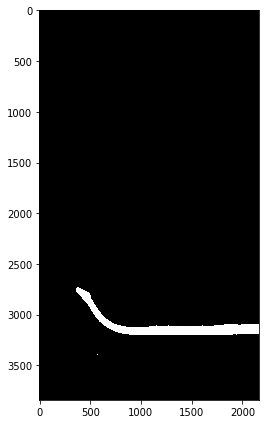

In [3]:
img = load_and_plot(img_path)

### The next step is to crop the image so that the picture only includes the snake from the head to the point of departure

The reason for this is that we are modeling the snake from the tip to the point it leaves the ground and the extra information is superfluous.

In [57]:
def crop(
    img: np.ndarray, left: int, right: int, top: int, bottom: int = 3300, size: int = 8
) -> np.ndarray:
    """
    Crop the image so only to tip to the point of departure are visible.

    Crop the image horizontally and vertically. Plot the result next to the
    original. The intention is that this function provides some interactivty
    in the cropping process.

    Parameters
    ----------
    img : np.ndarray
        Image array.
    left : int
        Drop all pixels before this on the left of the image.
    right : int
        Drop all pixels after this on the right of the image.
    top : int
        Drop all pixels above this at the top of the image.
    bottom : int
        Drop all pixels below this at the bottom of the image. Default=3300.
        I can provide a default here because we know where the bottom of the
        post is.
    size : int
        Size of plot.

    Returns
    -------
    img : np.ndarray
        Cropped image.
    """
    cropped = img[top:bottom, left:right]
    # plot_img(cropped)
    fig, ax = plt.subplots(1, 2, figsize=(size, size))

    ax[0].imshow(img, cmap=plt.cm.gray)
    ax[1].imshow(cropped, cmap=plt.cm.gray)
    plt.show()
    return cropped

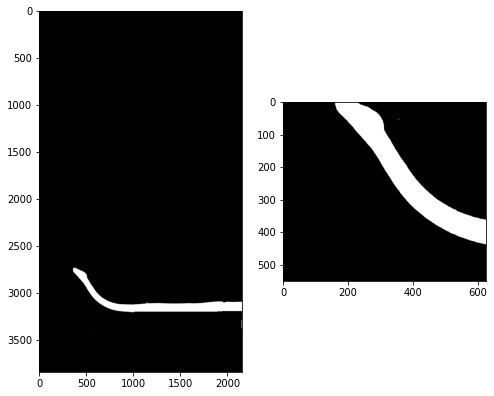

In [20]:
cropped = crop(img, left=200, right=825, top=2750)

### Now that we have the cropped image we need to do the extraction of the shape.

For now I will extract the front of the snake but I will also look into extracting the back and the center line. In reality I think the center line is most appropriate so I will work towards that.

In [50]:
def extract_front(cropped: np.ndarray) -> np.ndarray:
    """
    Extract the front of the snake from the image and return the pixel values
    describing the extracted shape.

    Parameters
    ----------
    cropped : np.ndarray
        Cropped image of snake.

    Returns
    -------
    front : np.ndarray
        A 2D array holding the x,y pixel values of the front of the snake.
    """
    rows = []
    columns = []
    for i in range(cropped.shape[0]):
        if np.any(cropped[i]):
            row_idx = i
            rows.append(row_idx)
            column_idx = np.where(cropped[i])[0][0]
            columns.append(column_idx)
    rows = np.array(rows)
    columns = np.array(columns)
    front = np.array(list(zip(columns, rows)))
    return front


def plot_outline(cropped: np.ndarray, outline: np.ndarray, size: int = 6) -> None:
    """
    Plot an outline of the shape of the snake.

    Parameters
    ----------
    cropped : np.ndarray
        Cropped image of the snake.
    outline : np.ndarray
        A 2D array giving pixel values for an outline.

    Returns
    -------
    """
    plt.figure(figsize=(size, size))
    skimage.io.imshow(cropped)
    plt.scatter(outline[:, 0], outline[:, 1], s=2, color="red")
    plt.show()

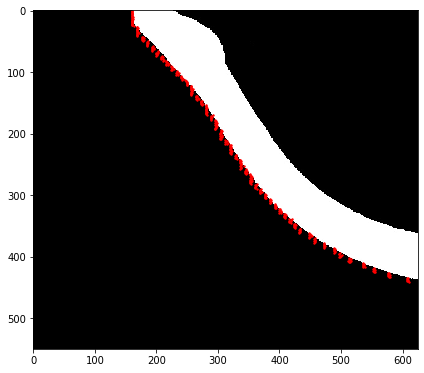

In [51]:
front = extract_front(cropped)
plot_outline(cropped, front)

### Now that we have extracted an outline from the image we need to interpolate the outline so we can do curvature analysis.

In order to fit a spline we need to create a parameter to fit on. We will use the distance as our parameter.

In [63]:
def get_distance_parameter(outline, px_per_cm=36.4):
    """
    Use the outline to construct a distance parameter.

    Parameters
    ----------
    outline : np.ndarray
        Outline shape (front, back, or center) of the snake.
    px_per_cm : float
        Magic number which set the distance scale (in cm) in the image. This
        number comes from knowing a physical distance in the image and seeing
        how many pixels that distance takes up.

    Returns
    ------
    distance : np.ndarray
        This array contains the distance between the outline points (in cm).
    """
    distance = np.cumsum(np.sqrt(np.sum(np.diff(outline, axis=0) ** 2, axis=1)))
    distance = np.insert(distance, 0, 0)
    distance = distance / px_per_cm
    return distance


def get_interpolation(distance: np.ndarray, outline: np.ndarray, num_points: int = 15):
    """
    Get the interpolation of the line.
    """
    interpolator = interp1d(distance, outline, axis=0)
    interp_points = np.linspace(distance.min(), distance.max(), num_points)
    interpolated_line = interpolator(interp_points)
    return interpolated_line


def plot_interpolated_line(
    cropped: np.ndarray,
    outline: np.ndarray,
    interpolated_line: np.ndarray,
    size: int = 8,
):
    """
    Plot the interpolation line over top of the snake image.

    Paramters
    ---------
    cropped : np.ndarray
        Cropped image of the snake.
    outline : np.ndarray
        A 2D array with the outline (front, back, or center) outline of the
        snake. The columns correspond to x and y pixel values.
    interpolated_line : np.ndarray
        A 2D array with the interpolation x and y pixel values for the outline.

    Returns
    -------
    """
    plt.figure(figsize=(size, size))
    skimage.io.imshow(cropped)
    plt.scatter(outline[:, 0], outline[:, 1], s=2, color="red")
    plt.scatter(interpolated_line[:, 0], interpolated_line[:, 1])
    plt.show()

In [64]:
distance = get_distance_parameter(outline=front)
interpolated_line = get_interpolation(distance, front)

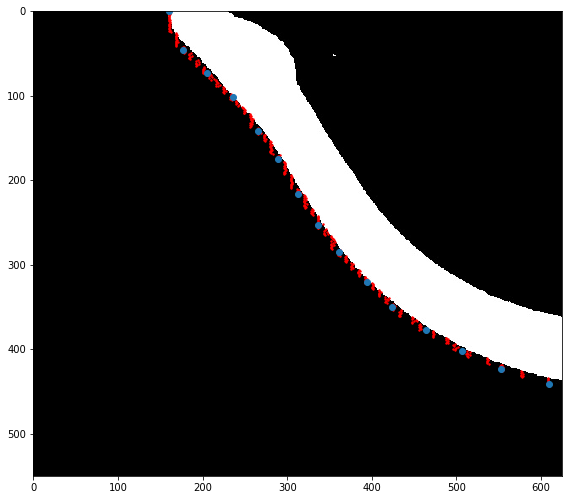

In [65]:
plot_interpolated_line(cropped, front, interpolated_line)

### Now that we have an outline of the snake extracted and we have a fit to the outline, we want to extract the curvature profile and plot that. 

We don't have an arc length parametrization because the magnitude of the tangent vector is not one. Instead we have a proper parameterization because the derivatives $\frac{dx}{dt}$ and $\frac{dy}{dt}$ exist everywhere and are not zero simultatneously. To compute curvature we can then use the [following formula](https://en.wikipedia.org/wiki/Curvature)

\begin{equation}
|\kappa| = \frac{|x'y''-x''y'|}{(x'^2+y'^2)^{\frac{3}{2}}}
\end{equation}